In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.externals import joblib
import time

# Color Features

In [135]:
# img = cv2.imread('/Users/ryank/Documents/datasets/vehicles/GTI_MiddleClose/image0000.png')
# img = cv2.imread('/hdd/datasets/vehicle_detection_data/vehicles/GTI_MiddleClose/image0000.png')
img = cv2.imread('data/vehicles/GTI_MiddleClose/image0000.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

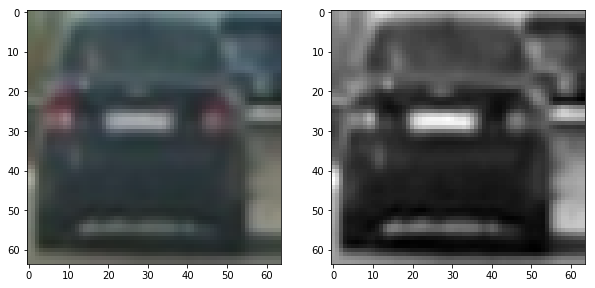

In [136]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(gray, cmap='gray')

In [137]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [138]:
color_features = color_hist(img)

<Container object of 96 artists>

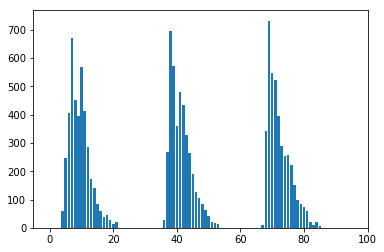

In [139]:
plt.bar(np.arange(len(color_features)), color_features)

In [140]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [141]:
spatial_features = bin_spatial(img, size=(8,8))

<Container object of 192 artists>

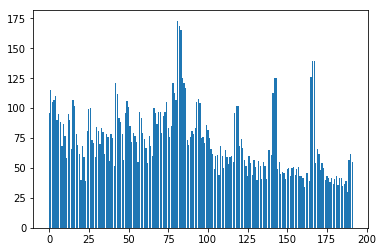

In [142]:
plt.bar(np.arange(len(spatial_features)), spatial_features)

# Gradient Features

In [143]:
# img = cv2.imread('/Users/ryank/Documents/datasets/vehicles/GTI_MiddleClose/image0000.png')
# img = cv2.imread('/hdd/datasets/vehicle_detection_data/vehicles/GTI_MiddleClose/image0000.png')
img = cv2.imread('data/vehicles/GTI_MiddleClose/image0000.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

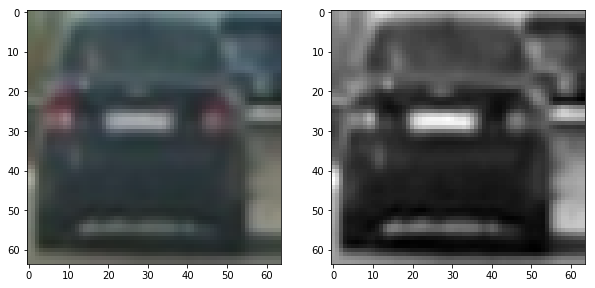

In [144]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(gray, cmap='gray')

In [145]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [146]:
pix_per_cell = 16
cell_per_block = 4
orient = 10

hog_features = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

/Users/qjh3/anaconda/envs/objdet/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


<Container object of 160 artists>

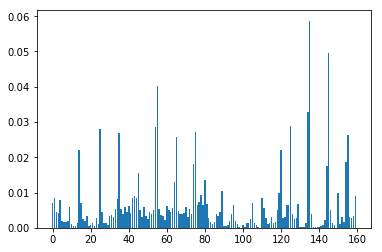

In [147]:
plt.bar(np.arange(len(hog_features)), hog_features)

# Combined Features

In [335]:
# # Define a function to extract features from a list of images
# def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
#                         pix_per_cell, cell_per_block, hog_channel):
#     file_features = []
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #print 'spat', spatial_features.shape
#         file_features.append(spatial_features)
#     if hist_feat == True:
#          # Apply color_hist()
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #print 'hist', hist_features.shape
#         file_features.append(hist_features)
#     if hog_feat == True:
#     # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=True))
#                 hog_features = np.ravel(hog_features)        
#         else:
#             feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
#             feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
#             hog_features = get_hog_features(feature_image[:,:], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#                 #print 'hog', hog_features.shape
#             # Append the new feature vector to the features list
#         file_features.append(hog_features)
#     return file_features

# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file_p in imgs:
#         file_features = []
#         image = cv2.imread(file_p) # Read in each imageone by one
#         # apply color conversion if other than 'RGB'
#         if color_space != 'RGB':
#             if color_space == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif color_space == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif color_space == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif color_space == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif color_space == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      
#         file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
#                         pix_per_cell, cell_per_block, hog_channel)
#         features.append(np.concatenate(file_features))
#         feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
#         file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
#                         pix_per_cell, cell_per_block, hog_channel)
#         features.append(np.concatenate(file_features))
#     return features # Return list of feature vectors

In [376]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(8, 8),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)[:,:,::-1]
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
            else:
#                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = get_hog_features(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        ###FLIP###
        file_features = []
        image = np.fliplr(image)
        feature_image = np.fliplr(feature_image)
#         feature_image = cv2.flip(feature_image,1)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
            else:
#                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = get_hog_features(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Vehicle / Non-vehicle Training Data

In [377]:
# cars = glob.glob('data/vehicles/**/*.png')[:1000]
# notcars = glob.glob('data/non-vehicles/**/*.png')[:1000]

cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

In [378]:
print(len(cars))
print(len(notcars))

8792
8968


In [461]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
# pix_per_cell = 16
# cell_per_block = 4
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
# orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True 

car_features = extract_features(cars, color_space=color_space, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
print('# car samples:',len(car_features))
print('# notcar samples:',len(notcar_features))

/Users/qjh3/anaconda/envs/objdet/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# car samples: 17584
# notcar samples: 17936


In [462]:
np.array(car_features).shape

(17584, 3020)

In [463]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [464]:
X_train_scaled.shape

(28416, 3020)

In [465]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [466]:
# svc = LinearSVC()

# param_grid = {"penalty": ["l1","l2"],
#               "loss": ["squared_hinge"],
#               "dual": [False],
#               "C": [0.01, 0.1, 1.0, 10.0]}
              
# grid_search = GridSearchCV(svc, param_grid=param_grid, cv=4)
# grid_search.fit(X_train, y_train)

# report(grid_search.cv_results_)

In [467]:
t = time.time()
# svc = LinearSVC(penalty='l1', dual=False, C=0.1)
svc = LinearSVC(loss='hinge')
svc.fit(X_train_scaled, y_train)
print(time.time() - t)

7.008687973022461


In [468]:
print('Test Accuracy:', round(svc.score(X_test_scaled, y_test), 3))

Test Accuracy: 0.988


In [469]:
joblib.dump(svc, 'model.pkl') 
# svc = joblib.load('model.pkl') 

['model.pkl']

In [470]:
clf = joblib.load('model.pkl')

# Sliding Windows

In [471]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [472]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            hog_features = get_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [473]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [474]:
# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(img)
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

In [475]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


/Users/qjh3/anaconda/envs/objdet/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


5.24 Seconds to process test images


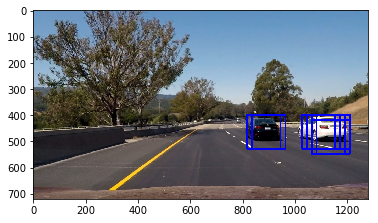

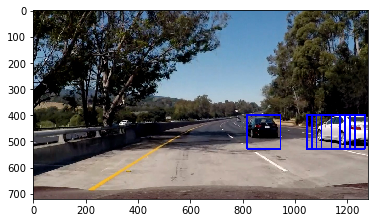

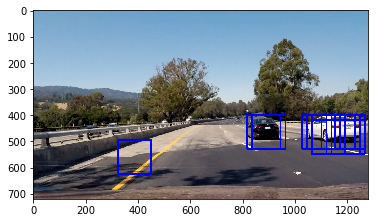

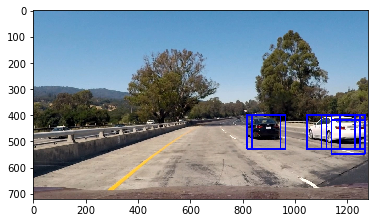

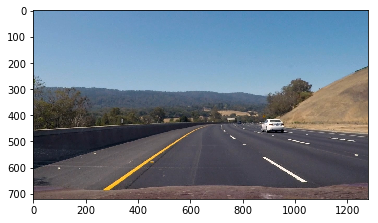

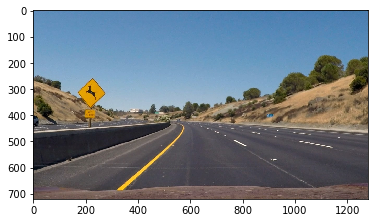

In [476]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)[:,:,::-1]
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                   hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')



In [175]:
# img = cv2.imread('test_images/test1.jpg')
# clr = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
# for channel in range(3):
#     plt.imshow(clr[:,:,channel], cmap='gray')
#     plt.show()

In [176]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

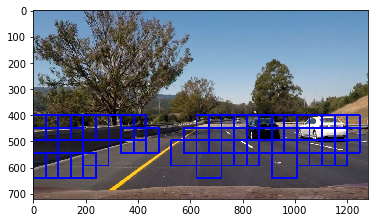

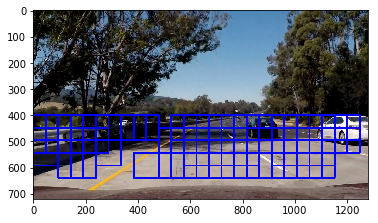

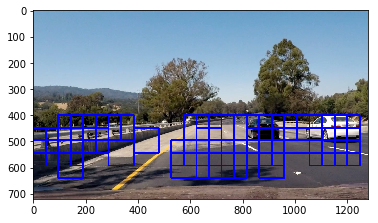

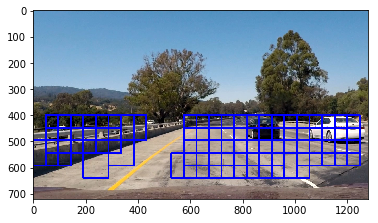

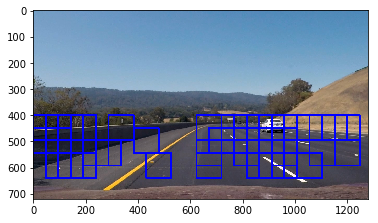

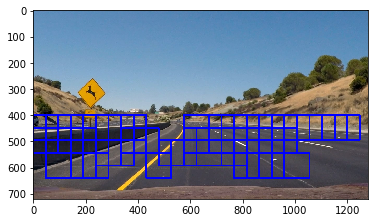

In [131]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            color_spaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb']
            hist_features = []
            for cspace in color_spaces:
                if cspace == 'HSV':
                    temp_image = cv2.cvtColor(subimg, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    temp_image = cv2.cvtColor(subimg, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    temp_image = cv2.cvtColor(subimg, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    temp_image = cv2.cvtColor(subimg, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    temp_image = cv2.cvtColor(subimg, cv2.COLOR_RGB2YCrCb)
                else:
                    temp_image = subimg.copy()
                temp_features = color_hist(temp_image, nbins=hist_bins)
                hist_features.append(temp_features)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, np.concatenate(hist_features), hog_features)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
for image_p in glob.glob('test_images/test*.jpg'):    
    img = cv2.imread(image_p)[:,:,::-1]
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    plt.imshow(out_img)
    plt.show()

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()